In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

from warpctc_pytorch import CTCLoss

/Users/adamschiller/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('data/IAM_handwriting')

In [4]:
!ls {PATH}

ascii           line_labels.csv paragraphs      words           words_chars.csv
chars.csv       lines           sentences       words.csv       xml
forms           models          tmp             words10.csv     xml.tgz


# Converting forms to paragraphs

## crop forms via xml info

In [24]:
import xml.etree.ElementTree as ET
xml = PATH/'xml'

def parse_xml(fname):
    tree = ET.parse(xml/fname)
    root = tree.getroot()
    
    words = []
    for part in root:
        for line in part:
            for word in line.findall('word'):
                for cmp in word:
                    x,y = int(cmp.attrib['x']), int(cmp.attrib['y'])
                    rx,ry = x+int(cmp.attrib['width']), y+int(cmp.attrib['height'])
                    words.append((x,y,rx,ry))
    
    # convert to numpy
    w = np.array(words)
    # create box w/ padding    # need top,left and height,width
    min_x = np.min(w[:,0])-50
    min_y = np.min(w[:,1])-50
    max_x = np.max(w[:,2])+50
    max_y = np.max(w[:,3])+50
    box = (min_x, min_y, max_x, max_y)
    return box

In [31]:
def crop_and_save(fname, box):
    im = Image.open(PATH/'forms'/fname)
    im = im.crop(box)
    im.save(PATH/'paragraphs'/fname)

In [4]:
folder = PATH/'forms'
files = []
for file in os.listdir(folder):
    files.append(file)
files.sort()

In [27]:
os.makedirs(PATH/'paragraphs', exist_ok=True)

In [40]:
for fname in files:
    box = parse_xml(fname[:-4]+'.xml')
    crop_and_save(fname, box)

In [5]:
def show_rand_paragraph(fnames):
    r = random.randint(0, len(fnames))
    fname = fnames[r]
    im = Image.open(PATH/'paragraphs'/fname)
    print(fname)
    print(im.size)
    return im

a01-049.png
(2183, 2070)


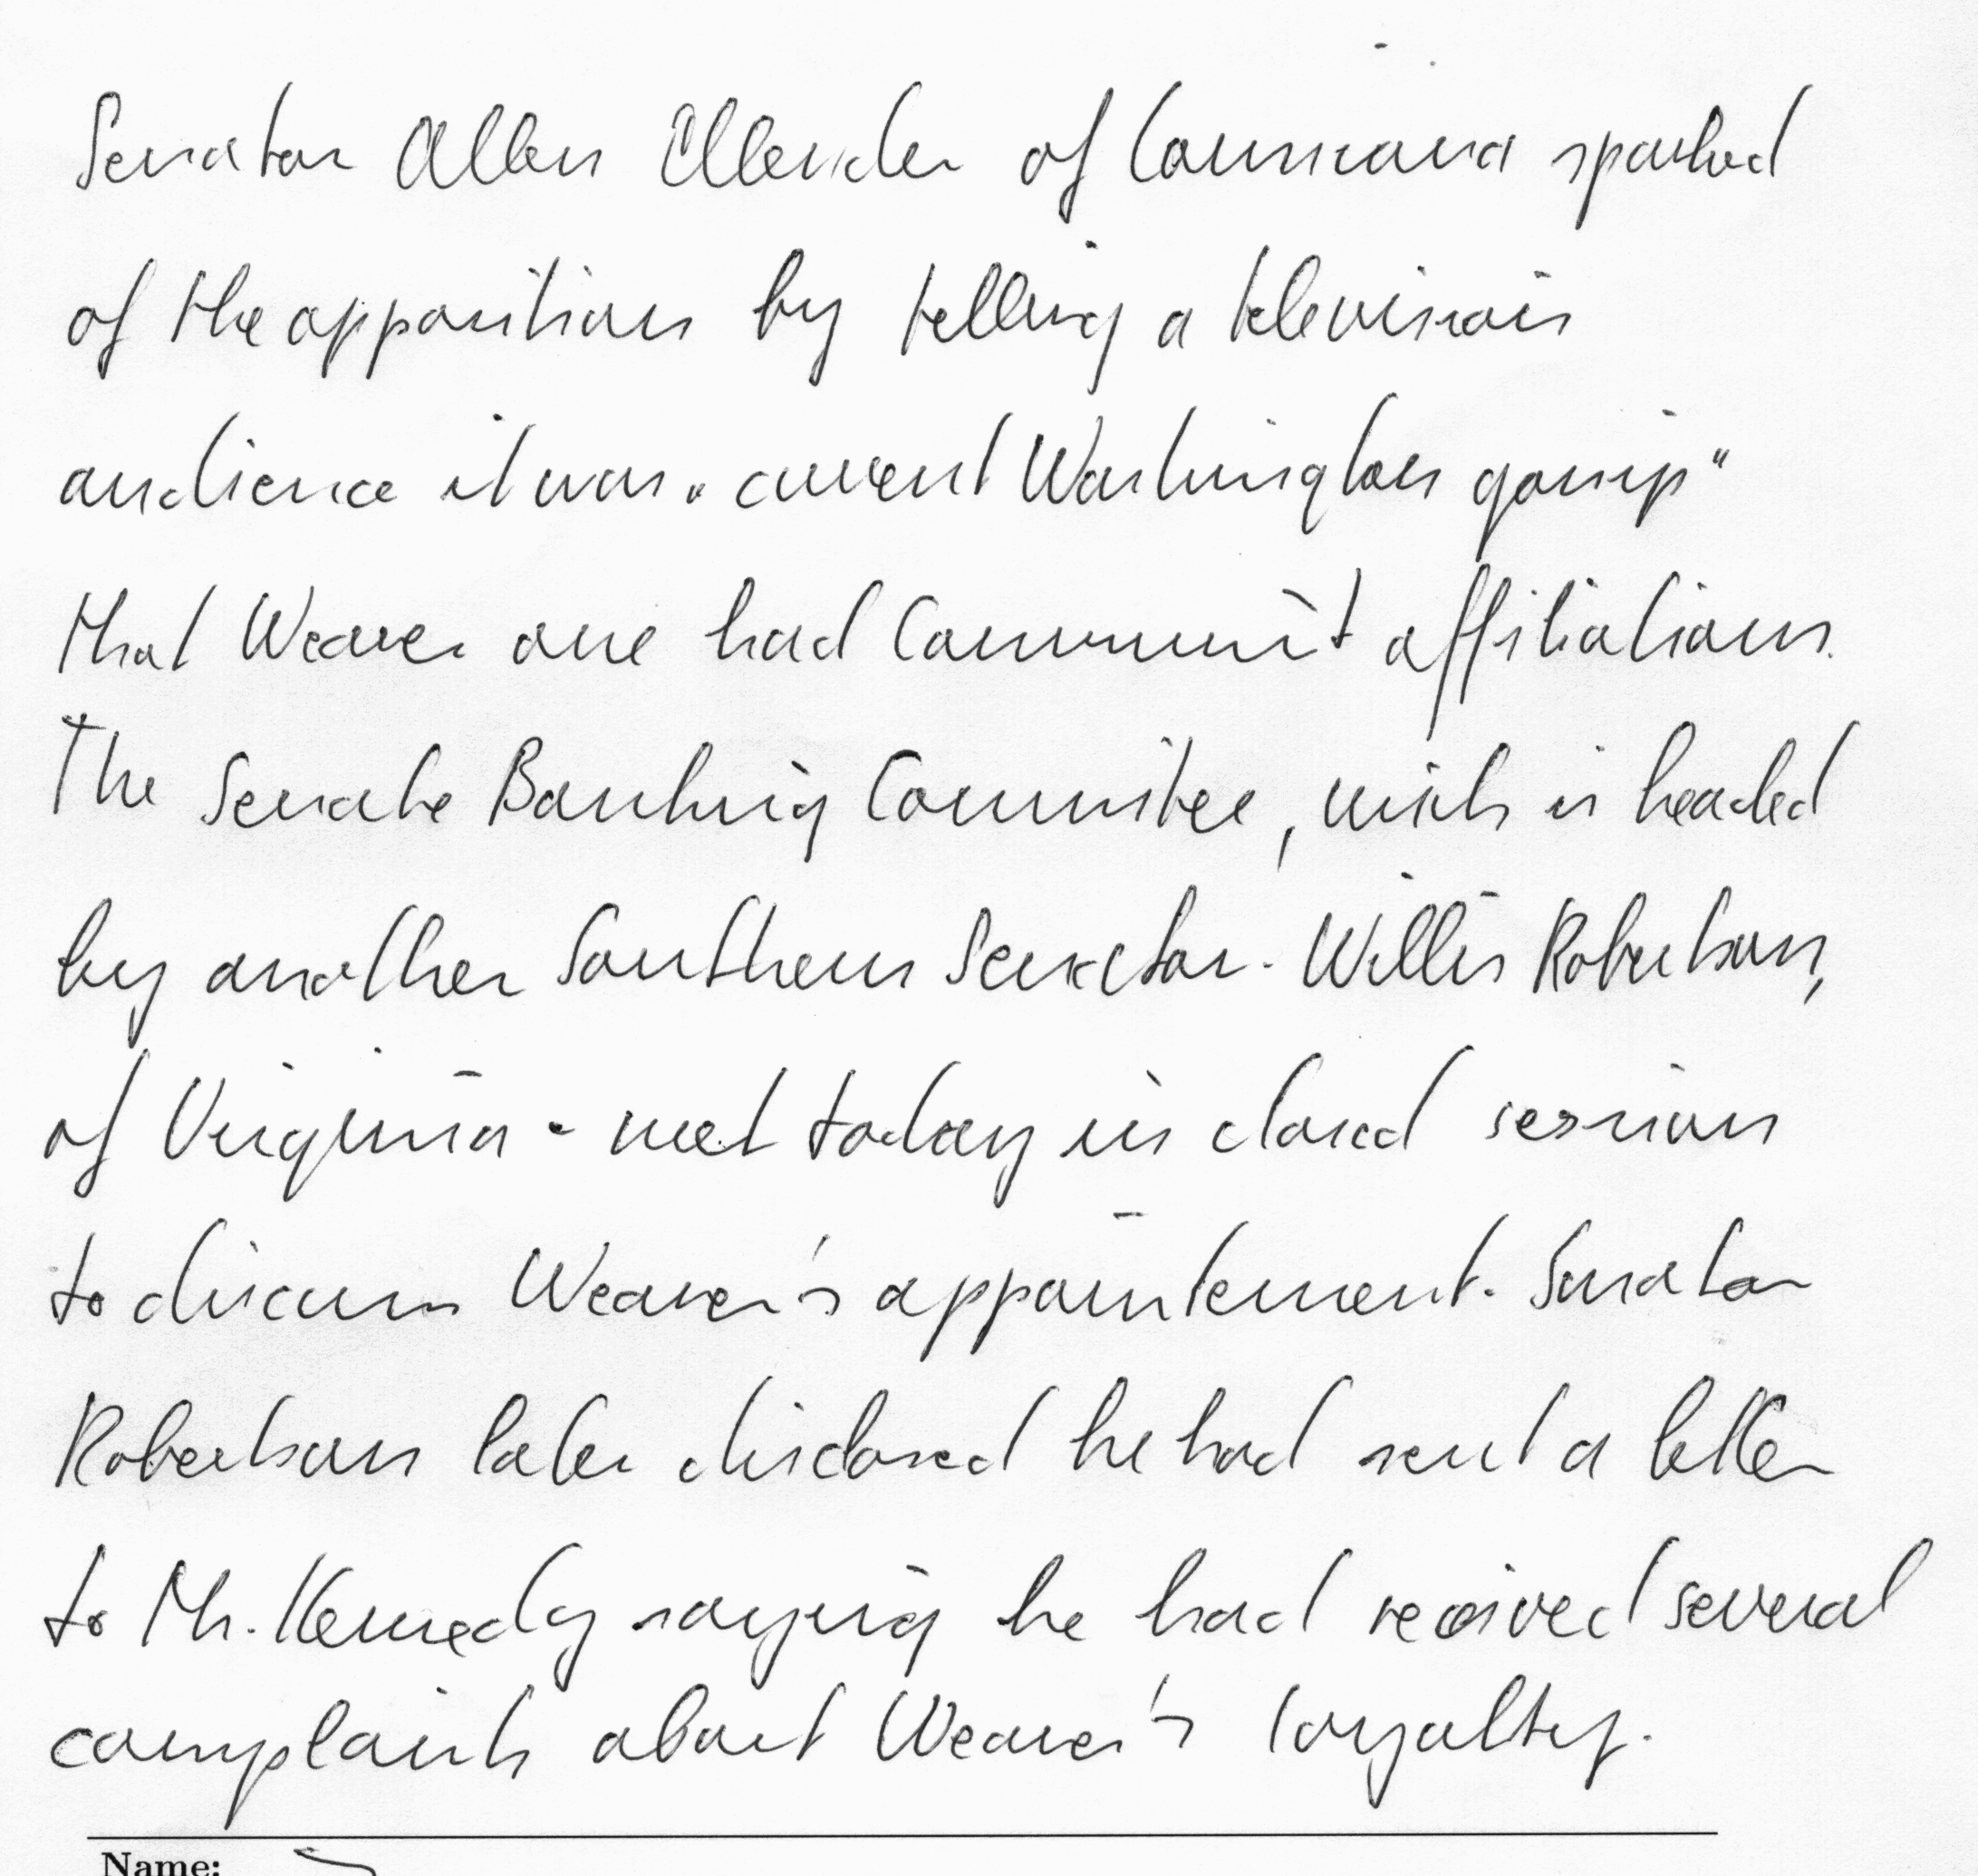

In [6]:
show_rand_paragraph(files)

# Combining Line labels into paragraph labels

In [7]:
lines = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
lines['text'] = lines.apply(lambda row: row.value.replace('|', ' '), axis=1)

In [34]:
lines.head(30)

filename result                                              value  \
0   a01-000u-00     ok                  A|MOVE|to|stop|Mr.|Gaitskell|from   
1   a01-000u-01     ok              nominating|any|more|Labour|life|Peers   
2   a01-000u-02     ok               is|to|be|made|at|a|meeting|of|Labour   
3   a01-000u-03    err                MPs|tomorrow|.|Mr.|Michael|Foot|has   
4   a01-000u-04     ok               put|down|a|resolution|on|the|subject   
5   a01-000u-05    err                 and|he|is|to|be|backed|by|Mr.|Will   
6   a01-000u-06     ok           Griffiths|,|MP|for|Manchester|Exchange|.   
7   a01-000x-00     ok       A|MOVE|to|stop|Mr.|Gaitskell|from|nominating   
8   a01-000x-01     ok      any|more|Labour|life|Peers|is|to|be|made|at|a   
9   a01-000x-02     ok      meeting|of|Labour|OMPs|tomorrow|.|Mr.|Michael   
10  a01-000x-03     ok      Foot|has|put|down|a|resolution|on|the|subject   
11  a01-000x-04     ok     and|he|is|to|be|backed|by|Mr.|Will|Griffiths|,   
12  a01-000x-05     ok                      OMP|for|Manchester|Exchange|.   
13   a01-003-00     ok  Though|they|may|gather|some|Left-wing|support|,|a   
14   a01-003-01     ok         large|majority|of|Labour|MPs|are|likely|to   
15   a01-003-02     ok      turn|down|the|Foot-Griffiths|resolution|.|Mr.   
16   a01-003-03     ok             Foot's|line|will|be|that|as|Labour|MPs   
17   a01-003-04     ok          opposed|the|Government|Bill|which|brought   
18   a01-003-05     ok        life|peers|into|existence|,|they|should|not   
19   a01-003-06     ok             now|put|forward|nominees|.|He|believes   
20   a01-003-07     ok        that|the|House|of|Lords|should|be|abolished   
21   a01-003-08     ok          and|that|Labour|should|not|take|any|steps   
22   a01-003-09    err     which|would|appear|to|"|prop|up|"|an|out-dated   
23   a01-003-10     ok                                      institution|.   
24  a01-003u-00     ok              Though|they|may|gather|some|Left-wing   
25  a01-003u-01     ok               support|,|a|large|majority|of|Labour   
26  a01-003u-02     ok              MPs|are|likely|to|turn|down|the|Foot-   
27  a01-003u-03    err        Griffiths|resolution|.|Mr.|Foot's|line|will   
28  a01-003u-04     ok                  be|that|as|Labour|MPs|opposed|the   
29  a01-003u-05     ok           Government|Bill|which|brought|life|peers   

                                                 text  
0                   A MOVE to stop Mr. Gaitskell from  
1               nominating any more Labour life Peers  
2                is to be made at a meeting of Labour  
3                 MPs tomorrow . Mr. Michael Foot has  
4                put down a resolution on the subject  
5                  and he is to be backed by Mr. Will  
6            Griffiths , MP for Manchester Exchange .  
7        A MOVE to stop Mr. Gaitskell from nominating  
8       any more Labour life Peers is to be made at a  
9       meeting of Labour OMPs tomorrow . Mr. Michael  
10      Foot has put down a resolution on the subject  
11     and he is to be backed by Mr. Will Griffiths ,  
12                      OMP for Manchester Exchange .  
13  Though they may gather some Left-wing support , a  
14         large majority of Labour MPs are likely to  
15      turn down the Foot-Griffiths resolution . Mr.  
16             Foot's line will be that as Labour MPs  
17          opposed the Government Bill which brought  
18        life peers into existence , they should not  
19             now put forward nominees . He believes  
20        that the House of Lords should be abolished  
21          and that Labour should not take any steps  
22     which would appear to " prop up " an out-dated  
23                                      institution .  
24              Though they may gather some Left-wing  
25               support , a large majority of Labour  
26              MPs are likely to turn down the Foot-  
27        Griffiths resolution . Mr. Foot's line wi

In [100]:
paragraphs = []
for fname in files:
    fname = fname[:-4]
    text = []
    rows = lines[lines.filename.str.startswith(fname+'-')]
    for i,t in rows.text.iteritems():
        text.append(t+' \n')
    paragraphs.append((fname+'.png', ''.join(text)))

In [51]:
len(paragraphs), len(files)

(1539, 1539)

In [39]:
len(files)

1539

In [101]:
df = pd.DataFrame(paragraphs, columns=['filename', 'text'])
df.head()

filename                                               text
0  a01-000u.png  A MOVE to stop Mr. Gaitskell from \nnominating...
1  a01-000x.png  A MOVE to stop Mr. Gaitskell from nominating \...
2   a01-003.png  Though they may gather some Left-wing support ...
3  a01-003u.png  Though they may gather some Left-wing \nsuppor...
4  a01-003x.png  Though they may gather some Left-wing support ...

# Word prep

### Tokenize/Numericalize

In [102]:
tokens = Tokenizer().proc_all_mp(partition_by_cores(df.text))

In [103]:
tokens

[['a',
  't_up',
  'move',
  'to',
  'stop',
  'mr',
  '.',
  'gaitskell',
  'from',
  '\n',
  'nominating',
  'any',
  'more',
  'labour',
  'life',
  'peers',
  '\n',
  'is',
  'to',
  'be',
  'made',
  'at',
  'a',
  'meeting',
  'of',
  'labour',
  '\n',
  'mps',
  'tomorrow',
  '.',
  'mr',
  '.',
  'michael',
  'foot',
  'has',
  '\n',
  'put',
  'down',
  'a',
  'resolution',
  'on',
  'the',
  'subject',
  '\n',
  'and',
  'he',
  'is',
  'to',
  'be',
  'backed',
  'by',
  'mr',
  '.',
  'will',
  '\n',
  'griffiths',
  ',',
  'mp',
  'for',
  'manchester',
  'exchange',
  '.',
  '\n'],
 ['a',
  't_up',
  'move',
  'to',
  'stop',
  'mr',
  '.',
  'gaitskell',
  'from',
  'nominating',
  '\n',
  'any',
  'more',
  'labour',
  'life',
  'peers',
  'is',
  'to',
  'be',
  'made',
  'at',
  'a',
  '\n',
  'meeting',
  'of',
  'labour',
  'omps',
  'tomorrow',
  '.',
  'mr',
  '.',
  'michael',
  '\n',
  'foot',
  'has',
  'put',
  'down',
  'a',
  'resolution',
  'on',
  'the',
 

In [104]:
idx = np.argmax([len(o) for o in tokens])
idx, len(tokens[idx]), tokens[idx]

(933,
 170,
 [' ',
  't_up',
  'when',
  'he',
  't_up',
  'saw',
  't_up',
  'trelawny',
  "'s",
  't_up',
  'printed',
  't_up',
  'letter',
  ',',
  '\n ',
  't_up',
  'lord',
  't_up',
  'sidney',
  't_up',
  'wrote',
  'to',
  't_up',
  'douglas',
  't_up',
  'kinnaird',
  '\n ',
  't_up',
  'saying',
  't_up',
  'that',
  'it',
  't_up',
  'was',
  't_up',
  'incorrect',
  't_up',
  'throughout',
  '.',
  'he',
  '\n ',
  't_up',
  'had',
  'no',
  't_up',
  'sooner',
  't_up',
  'heard',
  't_up',
  'from',
  't_up',
  'count',
  't_up',
  'gamba',
  't_up',
  'and',
  '\n ',
  't_up',
  'fletcher',
  't_up',
  'that',
  't_up',
  'byron',
  't_up',
  'would',
  't_up',
  'have',
  't_up',
  'wished',
  '\n ',
  't_up',
  'his',
  't_up',
  'body',
  'to',
  't_up',
  'return',
  'to',
  't_up',
  'england',
  't_up',
  'than',
  't_up',
  'that',
  '\n ',
  't_up',
  'course',
  't_up',
  'was',
  "'",
  't_up',
  'immediately',
  't_up',
  'carried',
  't_up',
  'into',
  '\n 

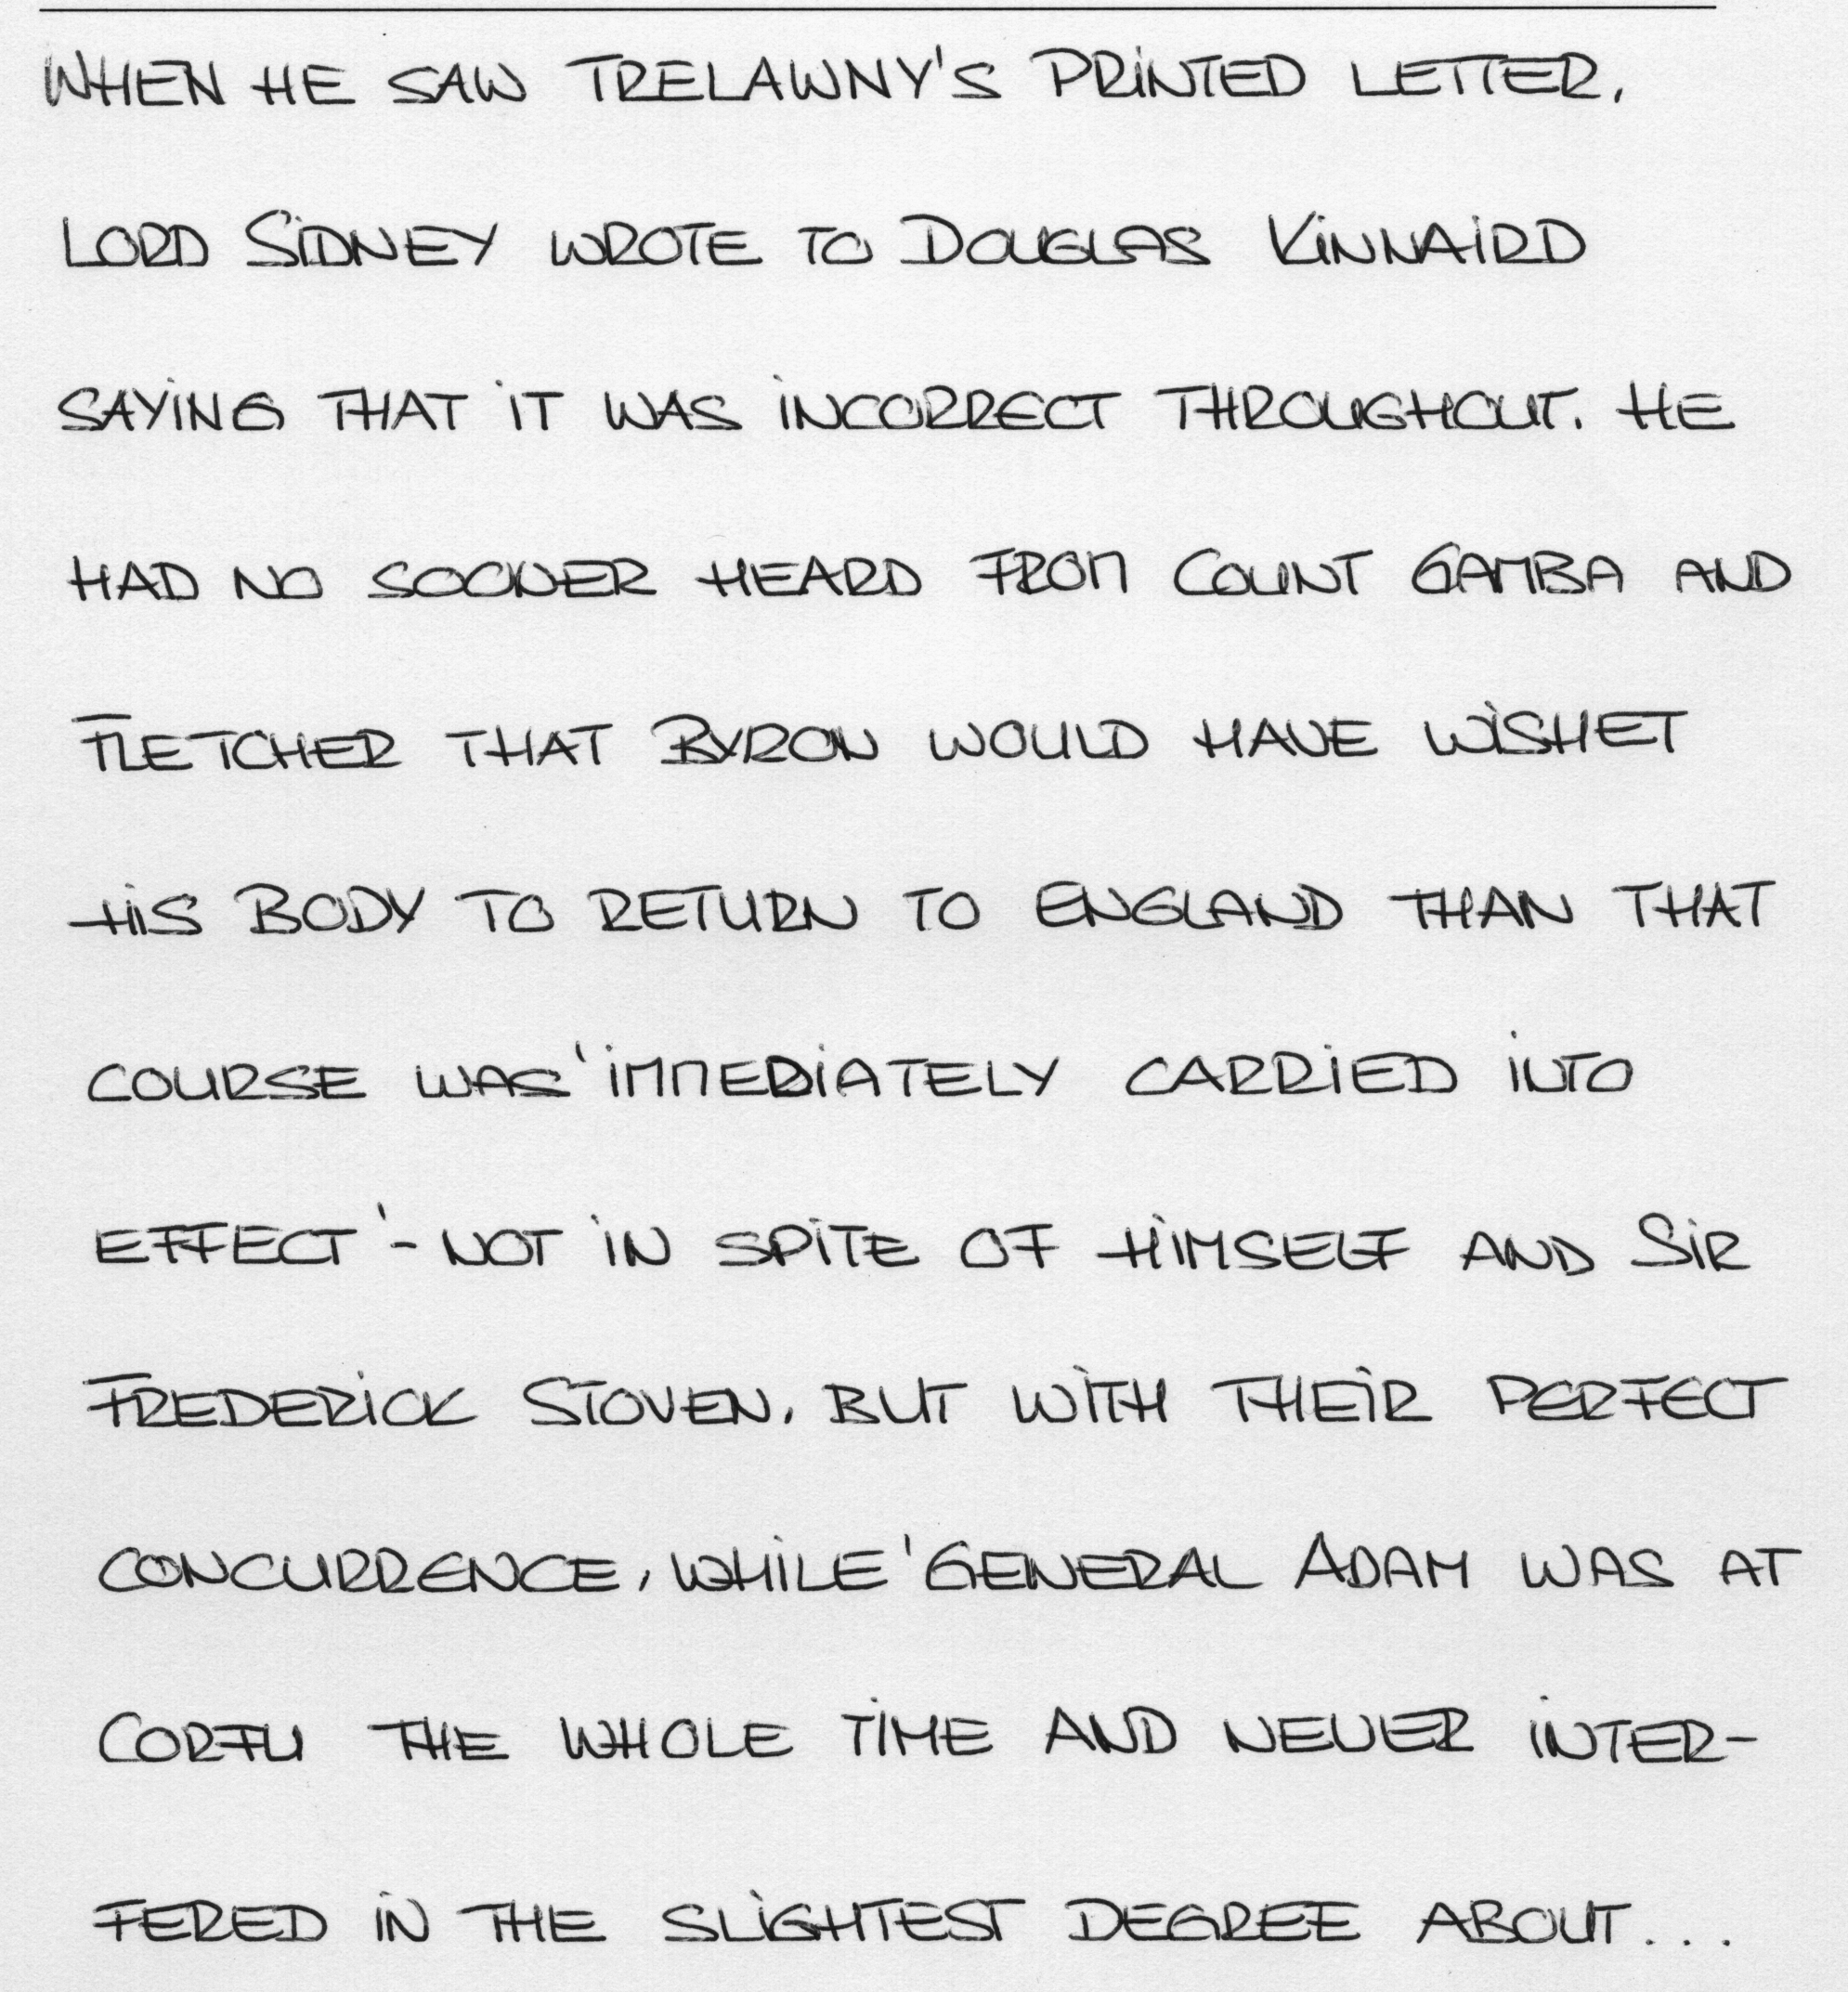

In [91]:
Image.open(PATH/'paragraphs'/'g07-000a.png')

In [105]:
np.percentile([len(o) for o in tokens], 98)

118.0

In [106]:
freq = Counter(word for line in tokens for word in line)
freq.most_common(25)

[('\n', 13265),
 ('the', 6491),
 ('.', 5561),
 (',', 5558),
 ('of', 3221),
 ('to', 2708),
 ('and', 2615),
 ('a', 2429),
 ('in', 2044),
 ('"', 1601),
 ('he', 1210),
 ('that', 1187),
 ('was', 1154),
 ('-', 1112),
 ('is', 1004),
 ('it', 983),
 ("'", 977),
 ('for', 890),
 ('as', 771),
 ('with', 766),
 ('his', 761),
 ('i', 746),
 ('had', 742),
 ('be', 731),
 ('on', 729)]

In [111]:
max_vocab=40000
min_freq=2

In [112]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_pad_')
itos.insert(1, '_unk_')

stoi = collections.defaultdict(lambda: 1, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[word] for word in line]) for line in tokens])

In [115]:
TMP_PATH = PATH/'tmp'
np.save(TMP_PATH/'paragraph_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'paragraph_itos.pkl', 'wb'))

In [114]:
df['ids'] = [' '.join(str(p) for p in o) for o in ids]
df.tail()

filename                                               text  \
1534  r06-121.png  At the school , which is charming , ci- \nvili...   
1535  r06-126.png  For his sake we chose the more \nserious of th...   
1536  r06-130.png  At the entrance of the cinema the \ndoorman wa...   
1537  r06-137.png  The doorman turned his attention \nto the next...   
1538  r06-143.png  In the train going back to London I sat \nbesi...   

                                                    ids  
1534  28 3 399 5 37 16 542 5 1 2 1 8 1597 5 3 86 223...  
1535  19 22 2303 44 1 3 65 2 2527 6 3 86 1748 13 47 ...  
1536  28 3 2900 6 3 1075 3 2 1 14 1291 10 1053 19 12...  
1537  3 1 394 22 1499 2 7 3 272 742 15 3115 1 39 3 2...  
1538  10 3 873 160 116 7 201 23 714 2 1394 144 1301 ...

### CSV

In [117]:
CSV = PATH/'paragraphs.csv'
# df.to_csv(csv, columns=['filename', 'ids'], index=False)

In [ ]:
df = pd.read_csv(CSV)

In [118]:
val_idxs = np.array(df.sample(frac=0.15).index)
len(val_idxs)

231

### Preprocess (rotate, normalize)

In [164]:
f = resnet34
sz = 500
bs = 10

In [165]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'paragraphs', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [166]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [167]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

### Verify transforms

In [176]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ' '.join([itos[i] for i in ints])

In [127]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

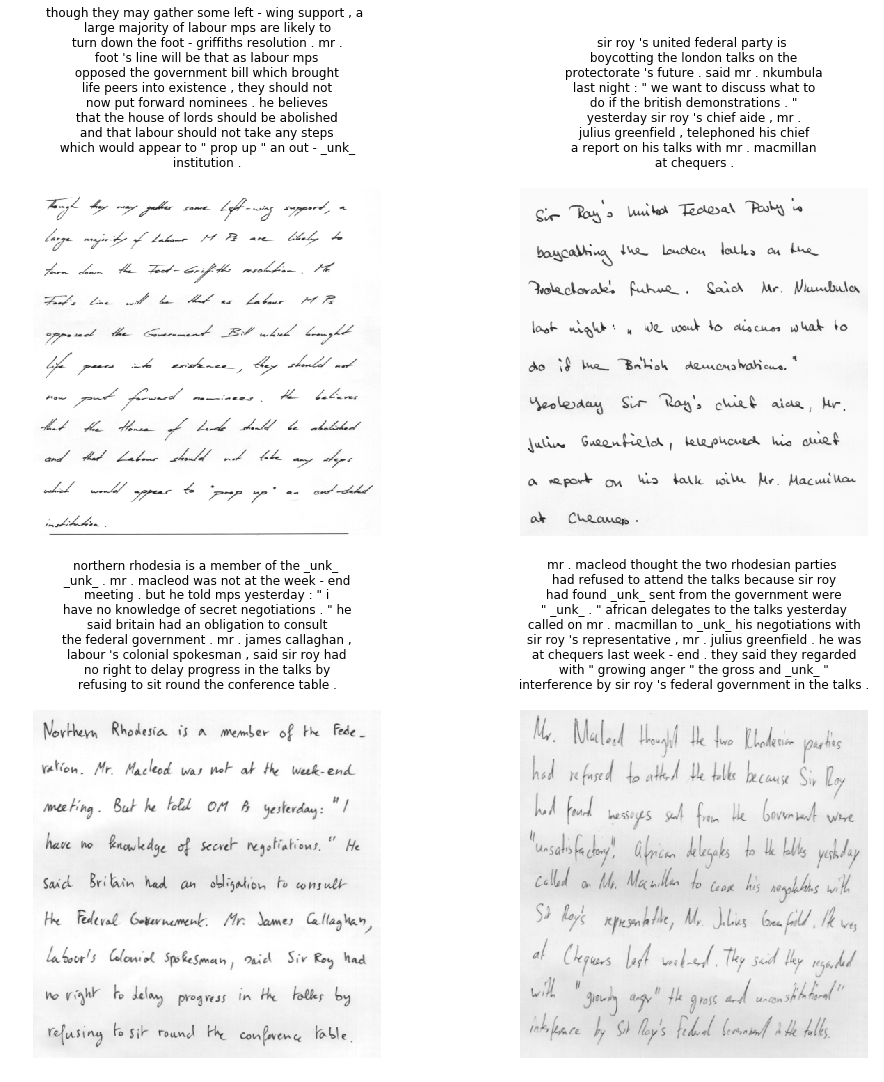

In [177]:
fig, axes = plt.subplots(2,2, gridspec_kw={'hspace': 0.5}, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(x[i], ax=ax, title=t)

## CTC

In [178]:
ctc_loss = CTCLoss()
# ctc_loss = nn.CTCLoss()  #pytorch master branch (unreleased)

In [179]:
def custom_loss(input, target):
    bs,sl = target.size()      #=> ([bs, sl])
    _,sl_in,vs = input.size()  #=> ([bs, 16, 80])
    inp = input.permute(1,0,2) #=> ([sl_in, bs, 80])
    
    inp_lens = torch.full((bs,), sl_in, dtype=torch.int32)
    
    ##NOTE: inp => gpu, everything else on cpu!!
    
    # need to remove 0s from labels (same as ctc blank character)
    targ = []
    targ_lens = []
    for i in range(bs):
        t = target[i,:]
        # remove 0 padding from targets
        t = t[t.nonzero().squeeze(1)]
        targ.append(t)
        targ_lens.append(len(t))

    targ = torch.cat(targ).type(torch.int32).cpu()
    targ_lens = torch.tensor(targ_lens, dtype=torch.int32)
    
#     targ = target.reshape(bs*sl).type(torch.int32)
#     targ_lens = torch.full((bs,), sl, device=device, dtype=torch.int32)
    
    return ctc_loss(inp, targ, inp_lens, targ_lens)
    
    
    # inputs: Tensor of (seqLength x batch x vocab_size) containing output activations from network (before softmax)
    # targets: 1 dimensional Tensor containing all the targets of the batch in one large sequence
    # input_lens: Tensor of size (batch) containing size of each output sequence from the network
    # target_lens: Tensor of (batch) containing label length of each example

## Levenshtein Error Rate

In [ ]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))